In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import pickle
dump_directory = "/home/srivbane/shared/caringbridge/data/projects/place-project/DataResults/"

In [2]:
class Node:
    def __init__(self, val, num):
        self.val = val
        self.filenum = num
        self.next = None

    def __str__(self):
        return str(self.val)
    
class Chain:
    def __init__(self):
        self.head = None
        self.lastchange = 0
        self.length = 0
        self.tail = None
        
    def add_node(self,val,num):
        self.length += 1
        node = Node(val, num)
        p1 = self.head
        if p1 == None:
            self.head = node
        else:
            self.tail.next = node
        self.tail = node
    
    def getlast(self):
        return self.tail
    
    def getlength(self):
        return self.length

    def __str__(self):
        tbr = ""
        p1 = self.head
        while p1 != None:
            tbr += str(p1.val)+" -> "
            p1 = p1.next
        if len(tbr) > 2:
            return tbr[:-3]
        return tbr

In [3]:
def load(minute):
    folder_id = minute//60
    data = pickle.load(open(dump_directory+"LinkingResults/hour-"+str(folder_id)+"/links-"+str(minute).zfill(4)+".res", "rb"))
    return data

def get_merge(data):
    val = data.values()
    count_db = {}
    
    for x in val:
        for y in x:
            if y not in count_db:
                count_db[y] = 1
            else:
                count_db[y] += 1
    
    to_be_returned = []
    for x in count_db:
        if count_db[x] > 1:
            to_be_returned.append(x)
    return to_be_returned

In [28]:
chains_inprogress = []
chains_completed = []

splits_count = 0
merge_count = 0

for num in tqdm_notebook(range(898)):
    links = load(num)

    if num == 0:
        for x in links:
            new_chain = Chain()
            new_chain.add_node(x, num)
            new_chain.add_node(links[x][0], num+1)
            chains_inprogress.append(new_chain)
    else:
        merging_nodes = set(get_merge(links))
        
        for y in links:
            found = False
            if len(set(links[y]) & merging_nodes) > 0:             # MERGING NODES
                merge_count += 1
                continue

            for z in chains_inprogress:
                if z.getlast().val == y and z.lastchange != num:       
                    z.lastchange = num
                    found = True
                    if len(links[y]) > 1:                         # NODES SPLITTING
                        z.lastchange -= 1
                        splits_count += 1
                    else:
                        z.add_node(links[y][0], num+1)
                    break

            if not found:                                       # NEW CHAIN STARTING
                new_chain = Chain()
                new_chain.add_node(y, num)
                new_chain.add_node(links[y][0], num+1)
                new_chain.lastchange = num
                chains_inprogress.append(new_chain)

    to_be_removed = []
    
    for x in range(len(chains_inprogress)):
        if chains_inprogress[x].lastchange == num - 10:
            chains_completed.append(chains_inprogress[x])
            to_be_removed.append(x)
    
    for x in to_be_removed[::-1]:
        chains_inprogress.pop(x)
    

print ("Merge Count:", merge_count)
print ("Split Count:", splits_count)
print ("Completed Chains:", len(chains_completed))
print ("In-Progress Chains:", len(chains_inprogress))
print ("Total Chains:", len(chains_completed)+len(chains_inprogress))

chains_completed.extend(chains_inprogress)


Merge Count: 14208
Split Count: 6220
Completed Chains: 17118
In-Progress Chains: 674
Total Chains: 17792


In [29]:
def average_length(completed):
    l = 0
    for x in chains_completed:
        l += x.getlength()
    return l/len(chains_completed)
    
def maximum_length(chains_completed):
    max = 0
    for x in chains_completed:
        if x.getlength() > max:
            max = x.getlength()
    return max

def minimum_length(chains_completed):
    min = len(chains_completed)
    for x in chains_completed:
        if x.getlength() < min:
            min = x.getlength()
    return min

def distribution_length(chains_completed):
    distribution = []
    for x in chains_completed:
        distribution.append(x.getlength())
    return distribution

def distribution_histogram(distribution):
    plt.hist(distribution, bins=maximum_length(chains_completed))
    plt.ylabel('Number of Conflicts')
    plt.xlabel('Length of Conflict (minutes)')
    plt.yscale('log') 
    plt.show()

Minimum Length: 2
Maximum Length: 875
Average Length: 20.29310926258993


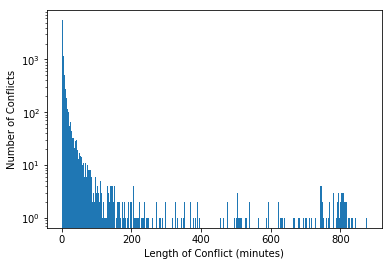

In [30]:
print ("Minimum Length:", minimum_length(chains_completed))
print ("Maximum Length:", maximum_length(chains_completed))
print ("Average Length:", average_length(chains_completed))
distribution_histogram(distribution_length(chains_completed))